In [247]:
import re
from sklearn.model_selection import train_test_split
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import warnings
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [127]:
docLabels = {}
docLabels['Admission_Date'] = ['DATE OF ADMISSION :\n' , 'ADMISSION DATE :\n' , 'Admission Date :\n']
docLabels['Discharge_Date'] = ['DATE OF DISCHARGE :\n' , 'DISCHARGE DATE :\n' , 'Discharge Date :\n' , 'Unsigned Discharge Date :\n' , 'Date of Discharge :\n' , 'Discharge Date / Time :\n']
docLabels['Diagnosis'] = ['PRINCIPAL DIAGNOSIS : :\n' , 'ADMITTING DIAGNOSIS :\n' , 'ADMISSION DIAGNOSES :\n' , 'Diagnosis :' , 'DIAGNOSIS :\n' , 'PRINCIPLE DIAGNOSIS :\n' , 'DIAGNOSES :\n' , 'PRIMARY DIAGNOSIS :\n' , 'ADMISSION DIAGNOSIS :\n' , 'PRINCIPAL DIAGNOSIS :\n' , 'SECONDARY DIAGNOSES :\n' , 'ASSOCIATED DIAGNOSIS :\n' , 'DISCHARGE DIAGNOSIS :\n' , 'OTHER DIAGNOSES :\n' , 'SECONDARY DIAGNOSIS :\n' , 'FINAL DIAGNOSIS :\n']
docLabels['Medication'] = ['Meds on admission :\n' , 'Antibiotics :\n' , '- Meds :\n' , 'Meds :\n' , 'MEDICATIONS UPON ADMISSION :\n' , 'MEDS ON ADMISSION :\n' , 'MEDS :\n' , 'MEDICATIONS ON ADMIT :\n' , 'Medications :\n' , 'MEDICATION ON ADMISSION :\n' , 'MEDICATIONS ON ADMISSION :\n' , 'ADMISSION MEDICATIONS :\n']
docLabels['Discharge_Condition'] = ['CONDITION UPON DISCHARGE :\n' , 'Condition on Discharge :\n' , 'Discharge Status :\n' , 'DISCHARGE DIAGNOSES :\n' , 'DISCHARGE CONDITION :\n' , 'CONDITION ON DISCHARGE :\n' , 'DISCHARGE DISPOSITION :\n' , 'DISPOSITION ON DISCHARGE :\n']
docLabels['Operations'] = ['PROCEDURES :\n' , 'PRINCIPLE PROCEDURE :\n' , 'PROCEDURE :\n' , 'PRINCIPAL PROCEDURES :\n' , 'ACTIVE PRINCIPAL PROCEDURE :\n' , 'OPERATIONS AND PROCEDURES :\n' , 'SPECIAL PROCEDURES :\n' , 'OPERATIONS / PROCEDURES :\n' , 'OTHER PROCEDURES :\n']
docLabels['Age'] = ['Age :\n']
docLabels['History'] = ['HISTORY :\n' , 'Past Medical History :\n' , 'Past Surgical History :\n' , 'Surgical history :\n' , 'FAMILY HISTORY : :\n']
docLabels['Sex'] = ['Sex :\n']
docLabels['Weight'] = ['Weight :\n']

In [128]:
docLabels.keys()

dict_keys(['Admission_Date', 'Discharge_Date', 'Diagnosis', 'Medication', 'Discharge_Condition', 'Operations', 'Age', 'History', 'Sex', 'Weight'])

In [129]:
def getKey(x):
    for i in docLabels:
        if x in docLabels[i]:
            return i
    return 'none'

In [130]:
datestrip = ['<PHI TYPE="DATE">' , '</PHI>']

In [131]:
Admission_Date = ''
Discharge_Date = ''
Diagnosis = ''
Medication = ''
Discharge_Condition = ''
Operations = ''
Age = ''
DOB = ''
Smoking = ''
History = ''
Sex = ''
Weight = ''
tab1 = []
ans = ''
line = 1
f = open("deid_surrogate_train_all_version2 - Copy.txt", "r")
rec = False
txt = ''
bsex = 0
bw = 0
c = 1
i = 0
for x in f:
    if 'RECORD' in x:
        rec = not rec
        if 'ID' in x:
            if c != 1:
                if Admission_Date == '' or Discharge_Date == '':
                    i = i + 1
                else:
                    if abs(int(Discharge_Date) - int(Admission_Date)) <= 2:
                        tab1.append([0,Diagnosis,Medication,Discharge_Condition,Operations,Age,History,Sex,Weight])
                    elif abs(int(Discharge_Date) - int(Admission_Date)) <= 7:
                        tab1.append([1,Diagnosis,Medication,Discharge_Condition,Operations,Age,History,Sex,Weight])
                    else:
                        tab1.append([2,Diagnosis,Medication,Discharge_Condition,Operations,Age,History,Sex,Weight])
                g.close()
            else:
                c = 2
            txt = 'records/'+re.sub('\D','',x) + '.txt'
            g = open(txt, "w")
            line = 1
            bsex = 0
            bw = 0
            Admission_Date = ''
            Discharge_Date = ''
            Diagnosis = ''
            Medication = ''
            Discharge_Condition = ''
            Operations = ''
            Age = ''
            Smoking = ''
            History = ''
            Sex = ''
            Weight = ''
        continue
    
    
    if txt != '' and x != '':
        
        if ':' in x and 'PHI' not in x and (len(x) < 30):
            ans = getKey(x)
            continue
        x = x.strip()
        if ans == 'Admission_date' or line <= 6 and ('DATE' in x):
            x = x.replace('<PHI TYPE="DATE">','')
            x = x.replace('</PHI>','')
            Admission_Date = Admission_Date + re.sub('\D','',x[2:4])
            line = 7
        elif ans == 'Discharge_Date':
            dd = x[17:21] + x[28:30]
            x = x.replace('<PHI TYPE="DATE">','')
            x = x.replace('</PHI>','')
            Discharge_Date = Discharge_Date + re.sub('\D','',x[2:4])
        elif ans == 'Diagnosis':
            Diagnosis = Diagnosis + x
        elif ans == 'Medication':
            Medication = Medication + x
        elif ans == 'Discharge_Condition':
            Discharge_Condition = Discharge_Condition + x
        elif ans == 'Operations':
            Operations = Operations + x
        elif ans == 'Age':
            x = x.replace('<PHI TYPE="DATE">','')
            x = x.replace('</PHI>','')
            Age = Age + re.sub('\D','',x)
        elif ans == 'History':
            History = History + x
        elif ans == 'Sex':
            if bsex == 0:
                if 'Male' in x:
                    Sex = 0
                if 'Female' in x:
                    Sex = 1
                bsex = 1
        elif ans == 'Weight':
            if bw == 0:
                w = re.sub('\D','',x)
                Weight = Weight + w[:7]
                bw =1

        g.write(x)
    line = line + 1

g.close()
f.close()

print(i, ' files skipped')

198  files skipped


In [132]:
df = pd.DataFrame(tab1)

In [133]:
df

,0,1,2,3,4,5,6,7,8
0,0,Carcinoma of the colon .Urinary tract infectio...,Folic acid .,,,,,,
1,1,ACUTE MYELOGENOUS LEUKEMIA .ACUTE MYELOGENOUS ...,,,,,,,
2,2,Right lung choriocarcinoma .,,,,,,,
3,0,,,Stable,,,,,
4,0,Failed left total hip replacement .,Nystatin powder to groin and lobular area b.i....,,,,,,
...,...,...,...,...,...,...,...,...,...
465,0,,,Stable,,,,,
466,0,,,Stable,,,,1,6103005
467,0,,Lipitor 10AllergiesNKDAPreop hct 36.4 3/16/04 ...,Stable,"<PHI TYPE=""DATE"">12/12</PHI>/04 <PHI TYPE=""DOC...",,,,
468,2,,,Satisfactory,OTHER TREATMENTS / PROCEDURES ( NOT IN O.R. )E...,,,,


In [134]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [135]:
encoder_df1 = pd.DataFrame(encoder.fit_transform(df[[1]]).toarray())
encode_df1_final = encoder_df1.sum(axis = 1)

encoder_df2 = pd.DataFrame(encoder.fit_transform(df[[2]]).toarray())
encode_df2_final = encoder_df2.sum(axis = 1)

encoder_df3 = pd.DataFrame(encoder.fit_transform(df[[3]]).toarray())
encode_df3_final = encoder_df3.sum(axis = 1)

encoder_df4 = pd.DataFrame(encoder.fit_transform(df[[4]]).toarray())
encode_df4_final = encoder_df4.sum(axis = 1)

encoder_df6 = pd.DataFrame(encoder.fit_transform(df[[6]]).toarray())
encode_df6_final = encoder_df6.sum(axis = 1)

In [136]:
encode_df1_final = encode_df1_final.to_frame()
encode_df2_final = encode_df2_final.to_frame()
encode_df3_final = encode_df3_final.to_frame()
encode_df4_final = encode_df4_final.to_frame()
encode_df6_final = encode_df6_final.to_frame()

In [137]:
df = df.drop(columns=[1,2,3,4,6])

In [138]:
encode_df1_final.columns = [1]
encode_df2_final.columns = [2]
encode_df3_final.columns = [3]
encode_df4_final.columns = [4]
encode_df6_final.columns = [6]

In [139]:
df[1] = encode_df1_final
df[2] = encode_df2_final
df[3] = encode_df3_final
df[4] = encode_df4_final
df[6] = encode_df6_final

In [140]:
frames = [df , encode_df1_final , encode_df2_final , encode_df3_final, encode_df4_final, encode_df6_final]

result = df

In [141]:
result

,0,5,7,8,1,2,3,4,6
0,0,,,,1.0,1.0,1.0,1.0,1.0
1,1,,,,1.0,1.0,1.0,1.0,1.0
2,2,,,,1.0,1.0,1.0,1.0,1.0
3,0,,,,1.0,1.0,1.0,1.0,1.0
4,0,,,,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
465,0,,,,1.0,1.0,1.0,1.0,1.0
466,0,,1,6103005,1.0,1.0,1.0,1.0,1.0
467,0,,,,1.0,1.0,1.0,1.0,1.0
468,2,,,,1.0,1.0,1.0,1.0,1.0


In [142]:
result.isna().sum().sum()

0

In [143]:
result.shape

(470, 9)

In [144]:
result.dtypes

0      int64
5     object
7     object
8     object
1    float64
2    float64
3    float64
4    float64
6    float64
dtype: object

In [145]:
result = result.replace(r'^\s*$', np.nan, regex=True)

In [146]:
result[5] = pd.to_numeric(result[5], errors='coerce').astype('float64')
result[7] = pd.to_numeric(result[7], errors='coerce').astype('float64')
result[8] = pd.to_numeric(result[8], errors='coerce').astype('float64')

In [301]:
result.head()

,0,5,7,8,1,2,3,4,6
0,0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
1,1,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
2,2,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
3,0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
4,0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0


In [148]:
y = result[0]

In [149]:
ally = pd.DataFrame(y)

In [150]:
ally[0].value_counts()

2    214
0    177
1     79
Name: 0, dtype: int64

In [240]:
x = result.drop(columns=[0])

In [241]:
x.shape

(470, 8)

In [242]:
x.isna().sum().sum()

1303

In [243]:
1303/(470*8)*100

34.65425531914894

**Simple Imputation**

In [155]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
simple = imputer.fit_transform(x.values)

In [156]:
simple.shape

(470, 8)

In [157]:
dftv = pd.DataFrame(simple)
dftv.isna().sum().sum()

0

*Splitting Data*

In [257]:
trainX_simple , testX_simple, trainy_simple, testY_simple = train_test_split(simple , ally , train_size=0.80, random_state=792)

*Models based on simple imputation dataset*

<AxesSubplot:title={'center':'Class distributions'}, xlabel='length of stay groups', ylabel='number of instances'>

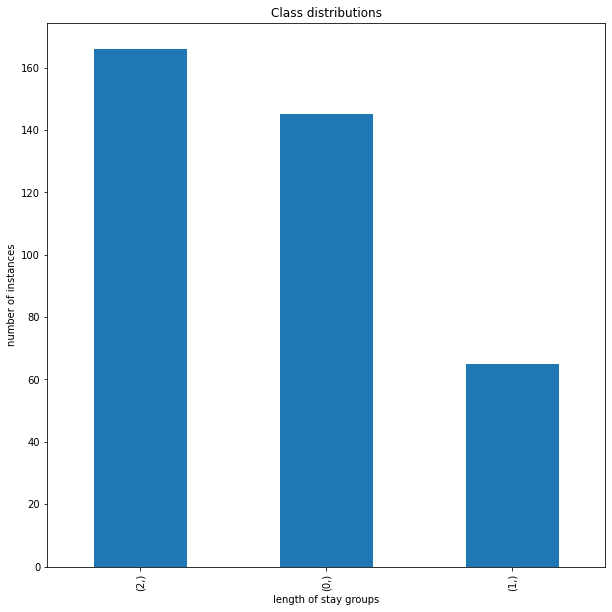

In [302]:
trainy_simple.value_counts().plot(kind='bar', title='Class distributions', xlabel='length of stay groups' , ylabel = 'number of instances')

In [305]:
trainy_simple.shape

(376, 1)

Mulltinomial Naive Bayes

Model accuracy score: 0.4894


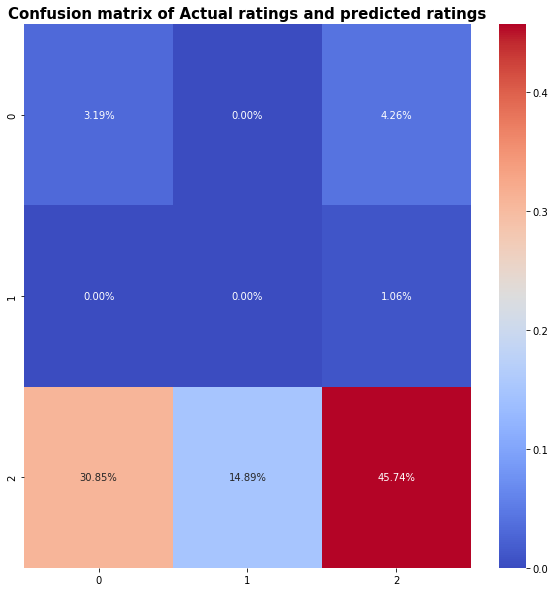

In [160]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mnb = MultinomialNB()

    mnb.fit(trainX_simple, trainy_simple)

    y_pred = mnb.predict(testX_simple)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_simple, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_simple)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')
                

Text(0, 0.5, 'Score')

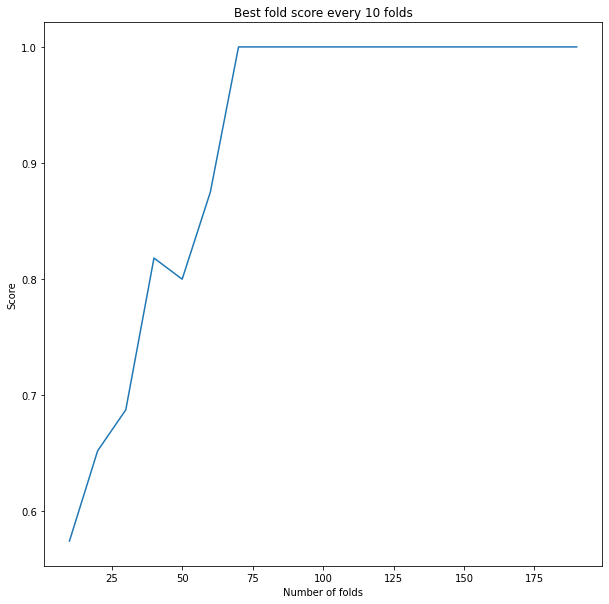

In [306]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(mnb, simple, ally, cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

In [308]:
np.asarray(cvs).mean()

0.9161749377016674

Decision Tree Classifier

Model accuracy score: 0.5213


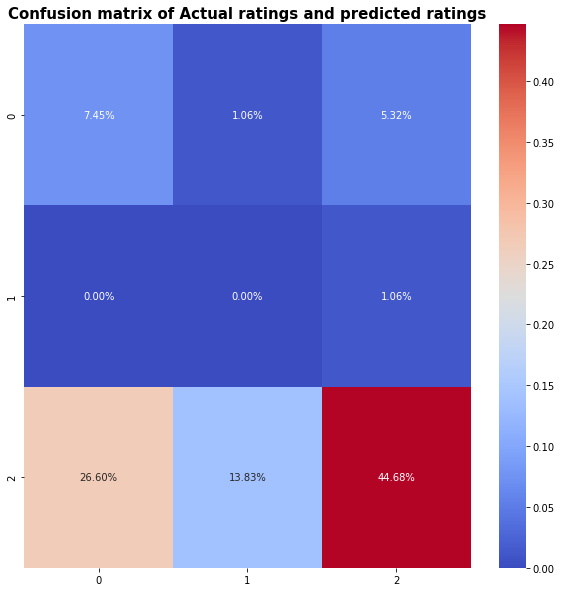

In [162]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dtc = DecisionTreeClassifier()

    dtc.fit(trainX_simple, trainy_simple)

    y_pred = dtc.predict(testX_simple)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_simple, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_simple)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

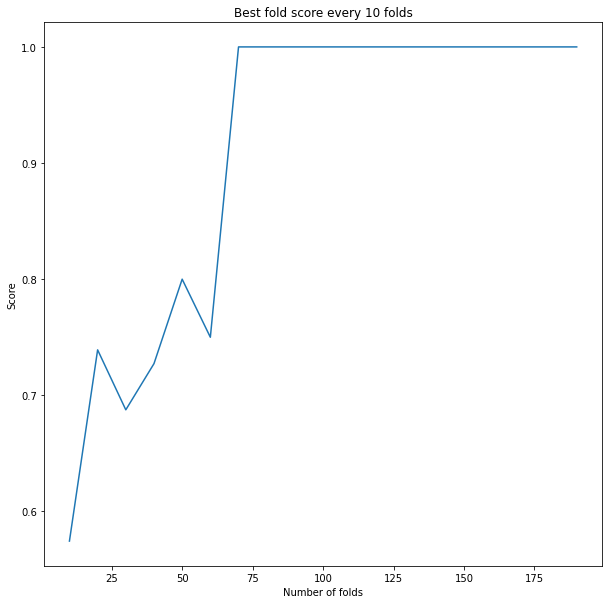

In [163]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(dtc, simple, ally, cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Random Forest Classifier

Model accuracy score: 0.5106


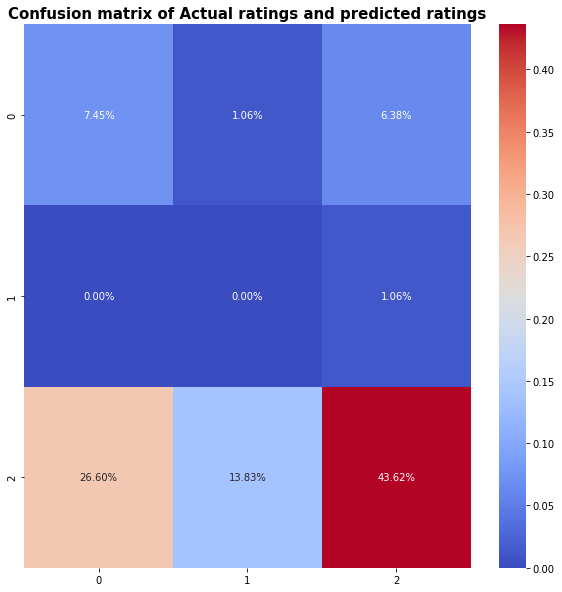

In [164]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rfc = RandomForestClassifier()

    rfc.fit(trainX_simple, trainy_simple)

    y_pred = rfc.predict(testX_simple)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_simple, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_simple)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

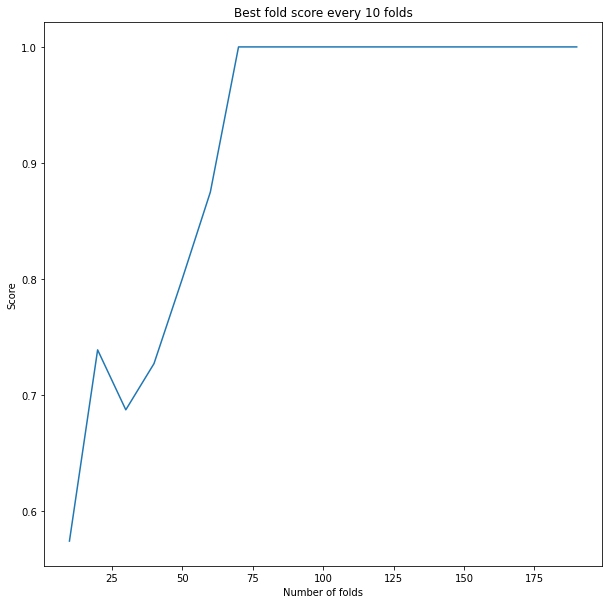

In [165]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(rfc, simple, ally, cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Light Gradient Boosting

Model accuracy score: 0.5213


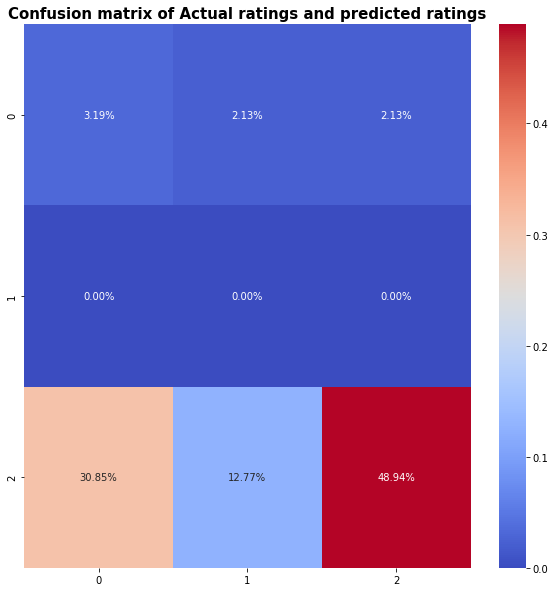

In [166]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lgbc = LGBMClassifier(
        objective="multiclass",
        n_estimators=200,
        metric="auc_mu",
        tree_learner="feature",
        random_state=42,
        num_iterations = 4000,
        learning_rate=0.1,
        silent=True,
        num_leaves = 3000,
        max_bin = 6)

    lgbc.fit(trainX_simple, trainy_simple)

    y_pred = lgbc.predict(testX_simple)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_simple, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_simple)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

15 : finished
16 : finished
17 : finished
18 : finished
19 : finished


Text(0, 0.5, 'Score')

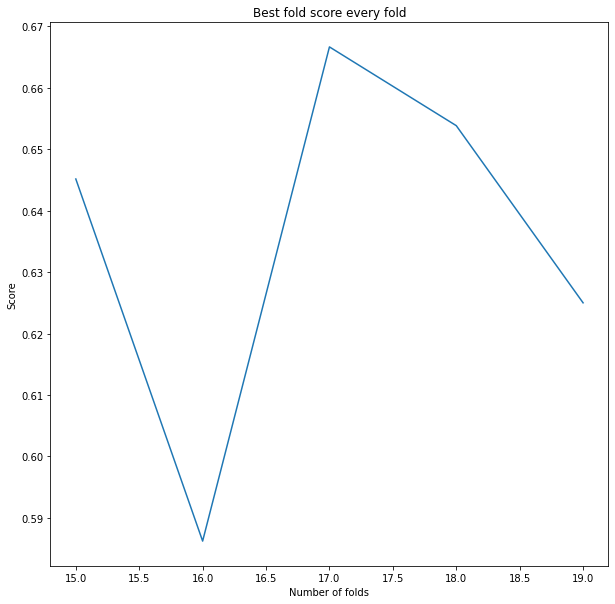

In [170]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(15,20):
        k_folds = KFold(n_splits = i)

        scores = cross_val_score(lgbc, simple, ally, cv = k_folds)

        f_num.append(i)
        cvs.append(scores.max())
        print(i,': finished')
plt.plot(f_num,cvs )
plt.title('Best fold score every fold')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Balanced Dataset

In [259]:
sm = SMOTE(random_state=32)
trainX_simple_balanced, trainy_simple_balanced = sm.fit_resample(pd.DataFrame(trainX_simple), pd.DataFrame(trainy_simple))
testX_simple_balanced, testY_simple_balanced = sm.fit_resample(pd.DataFrame(testX_simple), pd.DataFrame(testY_simple))

<AxesSubplot:title={'center':'Class distributions'}, xlabel='length of stay groups'>

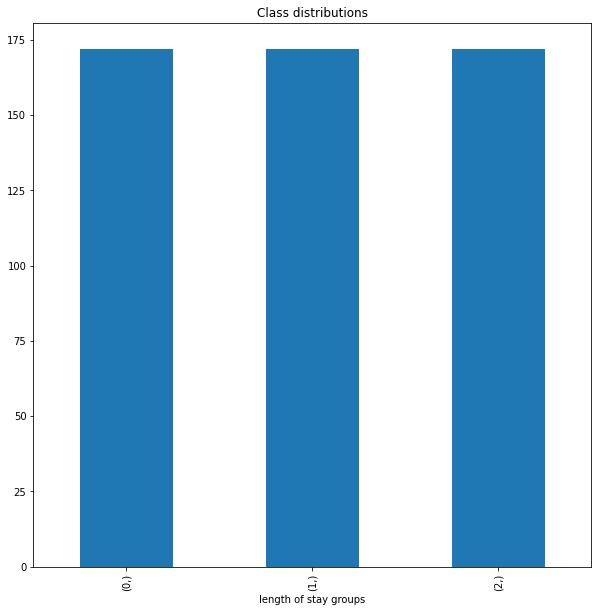

In [253]:
trainy_simple_balanced.value_counts().plot(kind='bar', title='Class distributions', xlabel='length of stay groups')

In [304]:
trainy_simple_balanced.shape

(498, 1)

Multinomial Naive Bayes on Balanced Dataset

Model accuracy score: 0.4097


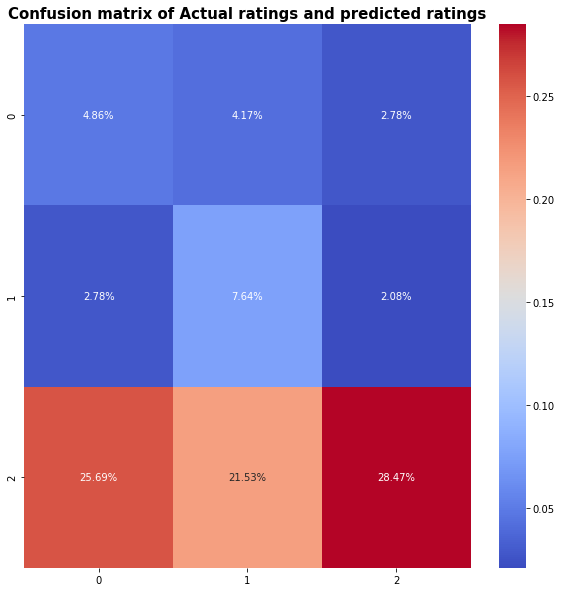

In [260]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mnb = MultinomialNB()

    mnb.fit(trainX_simple_balanced, trainy_simple_balanced)

    y_pred = mnb.predict(testX_simple_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_simple_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_simple_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

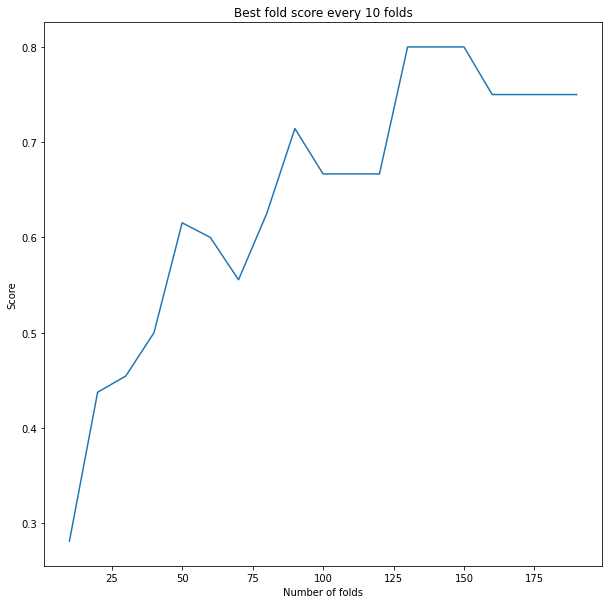

In [174]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(mnb, pd.concat([trainX_simple_balanced,testX_simple_balanced], axis=0), pd.concat([trainy_simple_balanced,testY_simple_balanced], axis=0), cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Decision tree Classifier with balanced dataset

Model accuracy score: 0.4097


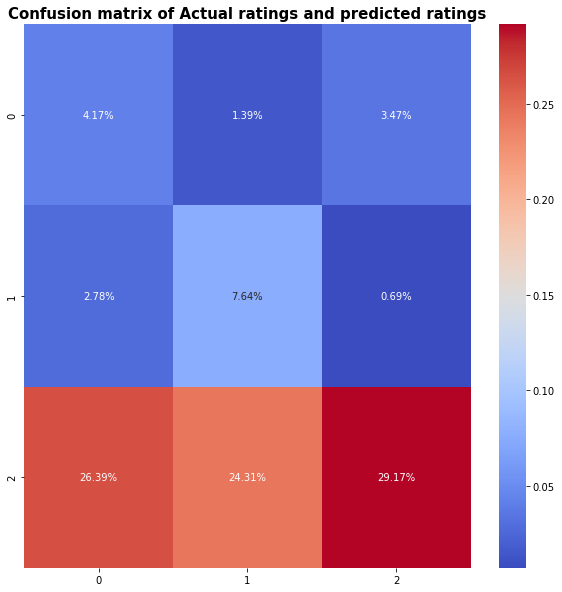

In [261]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dtc = DecisionTreeClassifier()

    dtc.fit(trainX_simple_balanced, trainy_simple_balanced)

    y_pred = dtc.predict(testX_simple_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_simple_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_simple_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

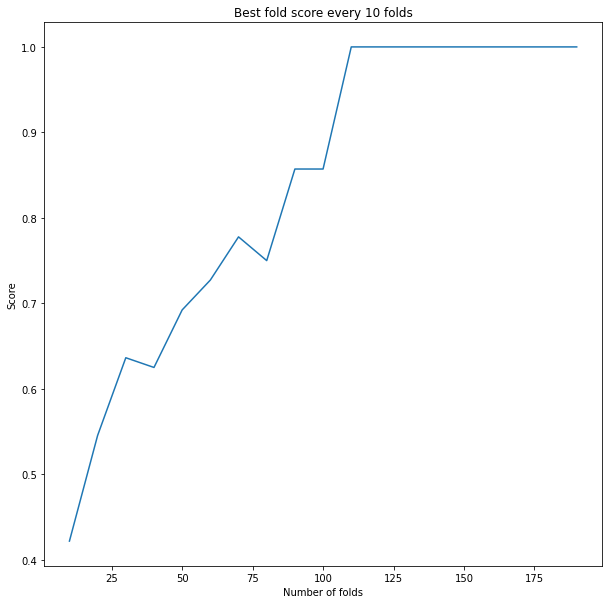

In [176]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(dtc, pd.concat([trainX_simple_balanced,testX_simple_balanced], axis=0), pd.concat([trainy_simple_balanced,testY_simple_balanced], axis=0), cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Random Forest classifier with balanced dataset

Model accuracy score: 0.4167


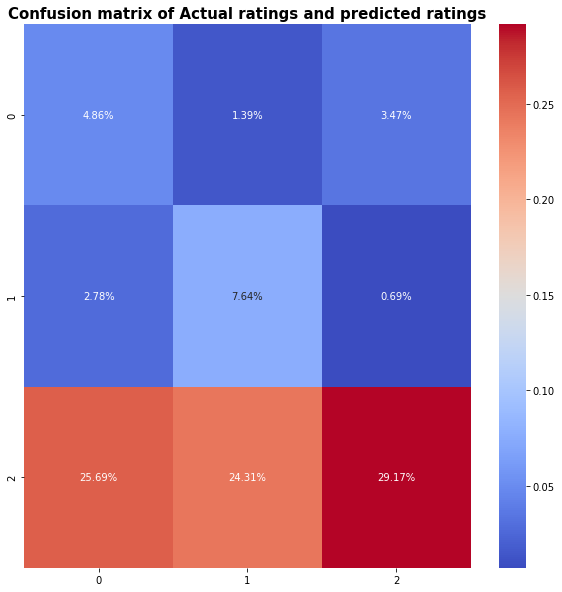

In [262]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rfc = RandomForestClassifier()

    rfc.fit(trainX_simple_balanced, trainy_simple_balanced)

    y_pred = rfc.predict(testX_simple_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_simple_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_simple_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

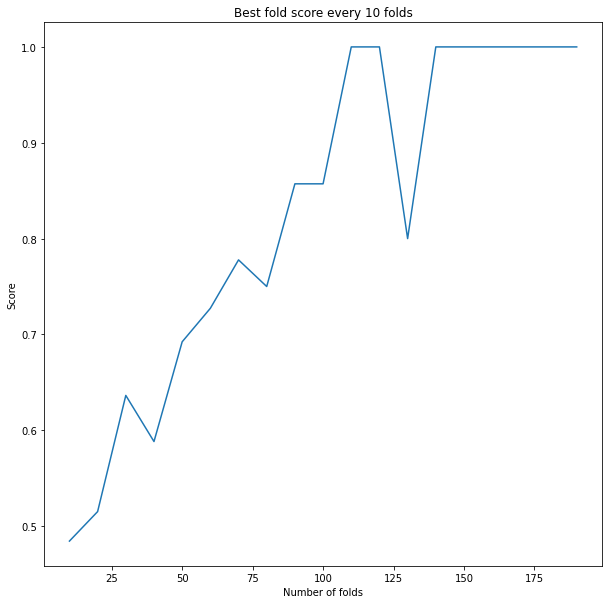

In [178]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(rfc, pd.concat([trainX_simple_balanced,testX_simple_balanced], axis=0), pd.concat([trainy_simple_balanced,testY_simple_balanced], axis=0), cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Light Gradient Boosting algorithm with balanced dataset

Model accuracy score: 0.3681


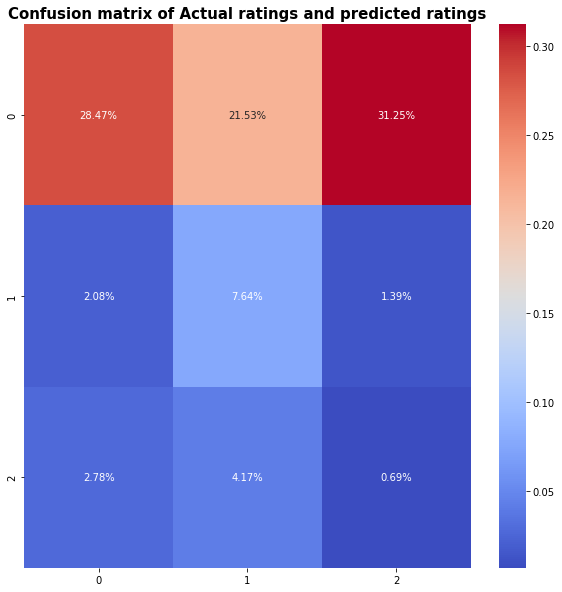

In [263]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lgbc = LGBMClassifier(
        objective="multiclass",
        n_estimators=200,
        metric="auc_mu",
        tree_learner="feature",
        random_state=42,
        num_iterations = 4000,
        learning_rate=0.1,
        silent=True,
        num_leaves = 3000,
        max_bin = 6)

    lgbc.fit(trainX_simple_balanced, trainy_simple_balanced)

    y_pred = lgbc.predict(testX_simple_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_simple_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_simple_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

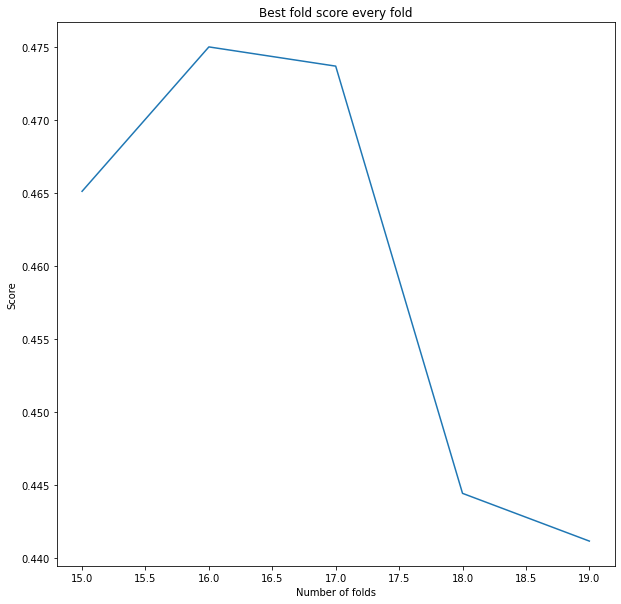

In [180]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(15,20):
        k_folds = KFold(n_splits = i)

        scores = cross_val_score(lgbc, pd.concat([trainX_simple_balanced,testX_simple_balanced], axis=0), pd.concat([trainy_simple_balanced,testY_simple_balanced], axis=0), cv = k_folds)

        f_num.append(i)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every fold')
plt.xlabel('Number of folds')
plt.ylabel('Score')

**KNN Imputation**

In [248]:
imputer = KNNImputer(n_neighbors=5) 
knn = imputer.fit_transform(x)

In [237]:
knn.shape

(470, 8)

In [238]:
dfknn = pd.DataFrame(knn)
dfknn.isna().sum().sum()

0

*Splitting Data*

In [264]:
trainX_knn , testX_knn, trainy_knn, testY_knn = train_test_split(dfknn , ally  , train_size=0.80, random_state=792)

*Models*

Multinomial Naive Bayes - KNN imputes negative values which cann not be handled by MNB

Decision tree classifier

Model accuracy score: 0.5213


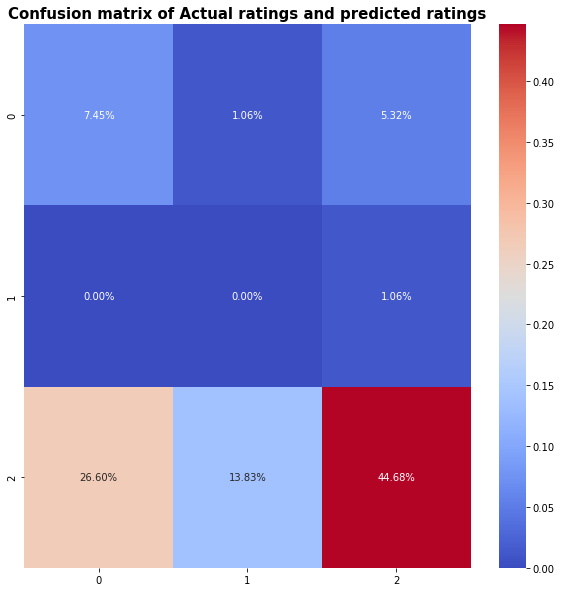

In [265]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dtc = DecisionTreeClassifier()

    dtc.fit(trainX_knn, trainy_knn)

    y_pred = dtc.predict(testX_knn)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_knn, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_knn)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

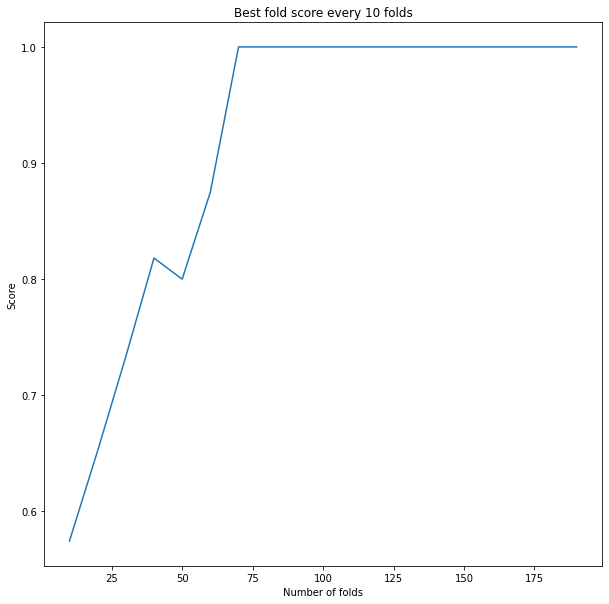

In [266]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(mnb, knn, ally, cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Random Forest Classifier

Model accuracy score: 0.5106


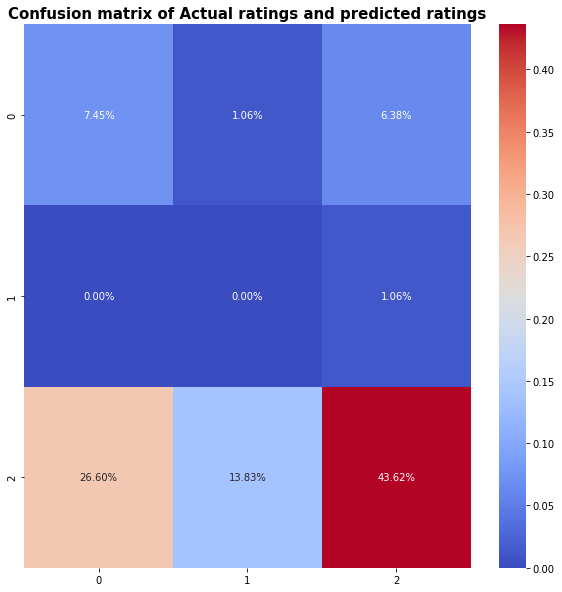

In [267]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rfc = RandomForestClassifier()

    rfc.fit(trainX_knn, trainy_knn)

    y_pred = rfc.predict(testX_knn)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_knn, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_knn)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

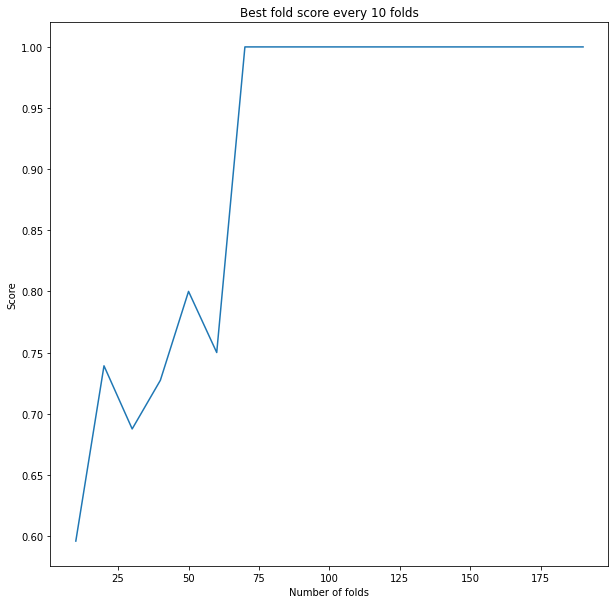

In [268]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(rfc, knn, ally, cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Light Gradient Boosting

Model accuracy score: 0.5213


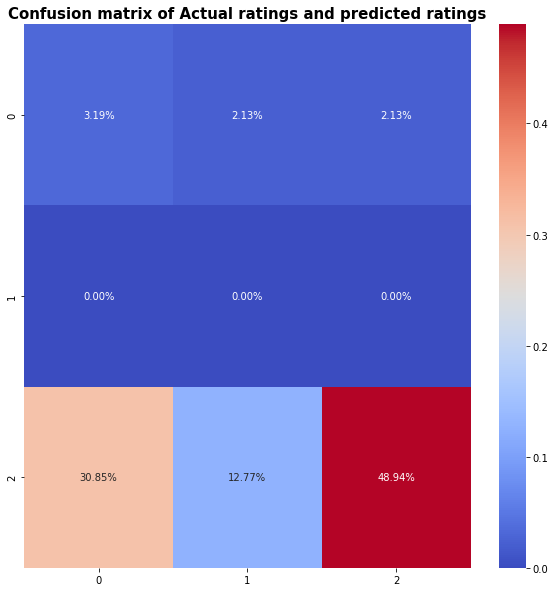

In [269]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lgbc = LGBMClassifier(
        objective="multiclass",
        n_estimators=200,
        metric="auc_mu",
        tree_learner="feature",
        random_state=42,
        num_iterations = 4000,
        learning_rate=0.1,
        silent=True,
        num_leaves = 3000,
        max_bin = 6)

    lgbc.fit(trainX_knn, trainy_knn)

    y_pred = lgbc.predict(testX_knn)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_knn, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_knn)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

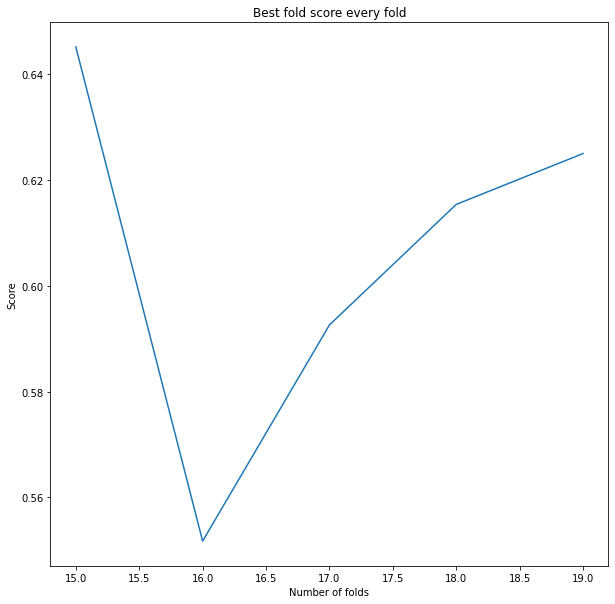

In [270]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(15,20):
        k_folds = KFold(n_splits = i)

        scores = cross_val_score(lgbc, knn, ally, cv = k_folds)

        f_num.append(i)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every fold')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Balanced Dataset

In [271]:
trainX_knn_balanced, trainy_knn_balanced = sm.fit_resample(pd.DataFrame(trainX_knn), pd.DataFrame(trainy_knn))
testX_knn_balanced, testY_knn_balanced = sm.fit_resample(pd.DataFrame(testX_knn), pd.DataFrame(testY_knn))

<AxesSubplot:title={'center':'Class distributions'}, xlabel='length of stay groups'>

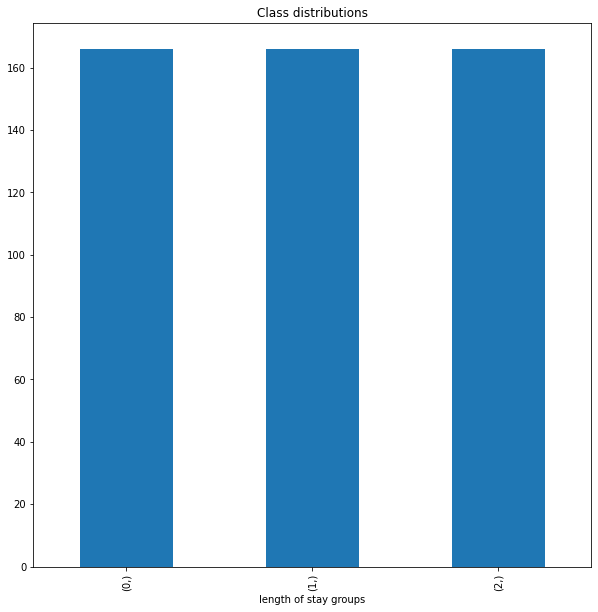

In [272]:
trainy_knn_balanced.value_counts().plot(kind='bar', title='Class distributions', xlabel='length of stay groups')

Decision tree Classifier with balanced dataset

Model accuracy score: 0.3958


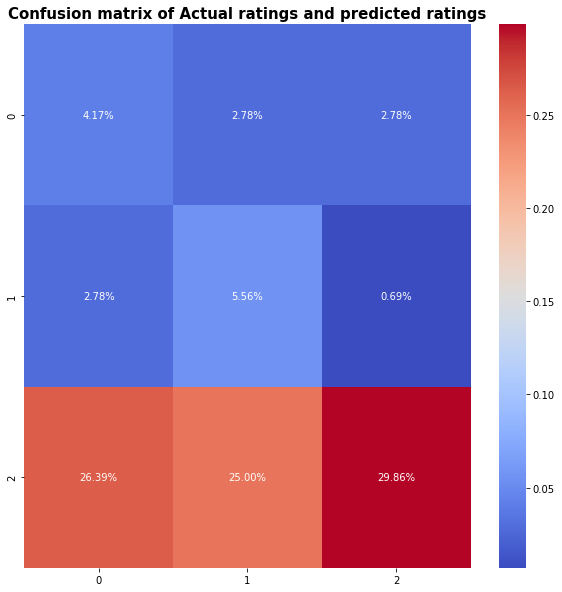

In [273]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dtc = DecisionTreeClassifier()

    dtc.fit(trainX_knn_balanced, trainy_knn_balanced)

    y_pred = dtc.predict(testX_knn_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_knn_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_knn_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

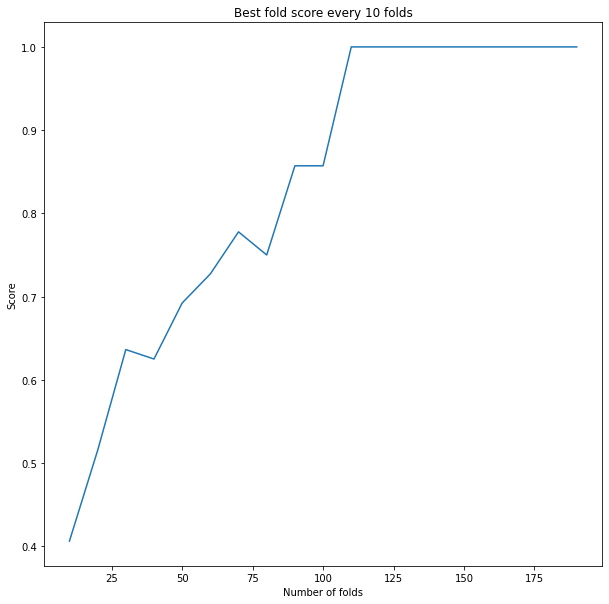

In [274]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(dtc, pd.concat([trainX_knn_balanced,testX_knn_balanced], axis=0), pd.concat([trainy_knn_balanced,testY_knn_balanced], axis=0), cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Random Forest classifier with balanced dataset

Model accuracy score: 0.3125


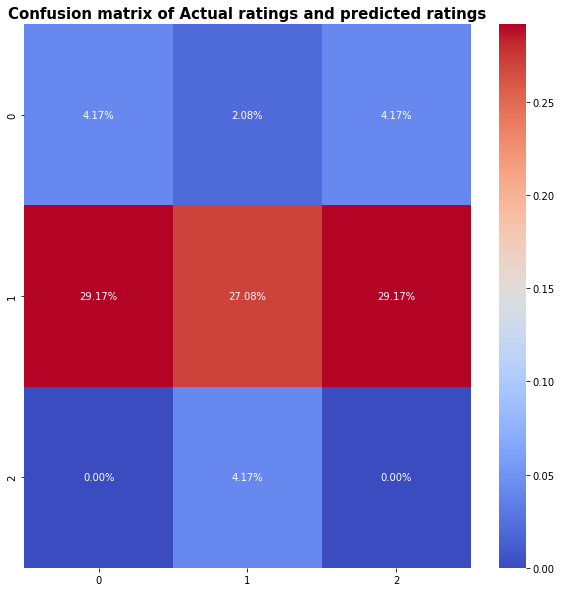

In [275]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rfc = RandomForestClassifier()

    rfc.fit(trainX_knn_balanced, trainy_knn_balanced)

    y_pred = rfc.predict(testX_knn_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_knn_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_knn_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

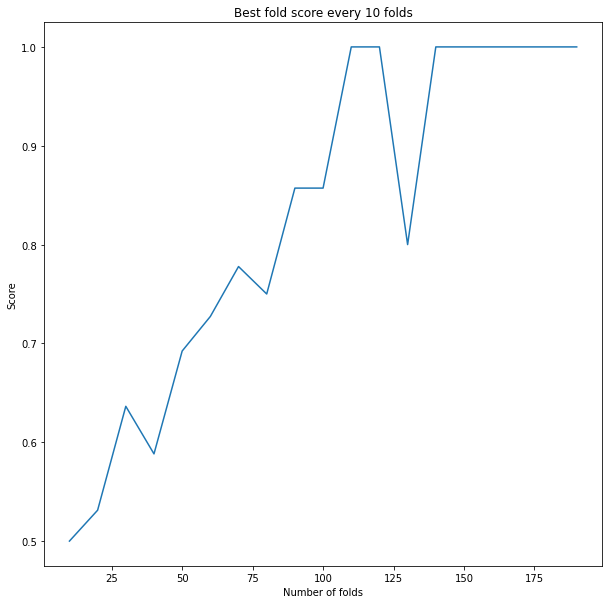

In [276]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(rfc, pd.concat([trainX_knn_balanced,testX_knn_balanced], axis=0), pd.concat([trainy_knn_balanced,testY_knn_balanced], axis=0), cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Light Gradient Boosting algorithm with balanced dataset

Model accuracy score: 0.3958


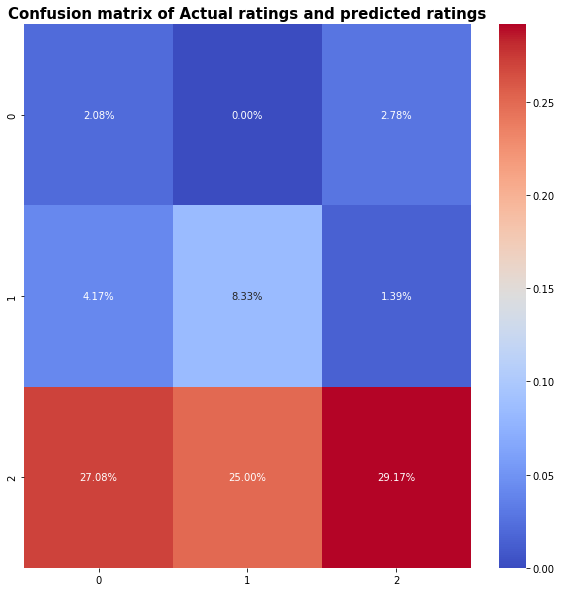

In [277]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lgbc = LGBMClassifier(
        objective="multiclass",
        n_estimators=200,
        metric="auc_mu",
        tree_learner="feature",
        random_state=42,
        num_iterations = 4000,
        learning_rate=0.1,
        silent=True,
        num_leaves = 3000,
        max_bin = 6)

    lgbc.fit(trainX_knn_balanced, trainy_knn_balanced)

    y_pred = lgbc.predict(testX_knn_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_knn_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_knn_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

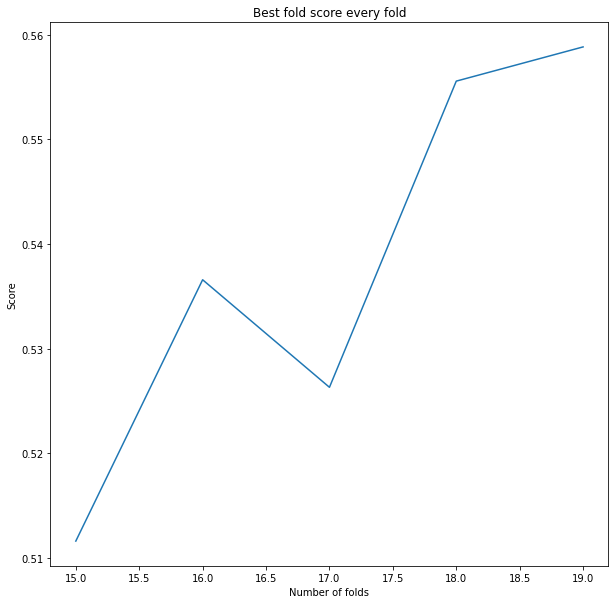

In [278]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(15,20):
        k_folds = KFold(n_splits = i)

        scores = cross_val_score(lgbc, pd.concat([trainX_knn_balanced,testX_knn_balanced], axis=0), pd.concat([trainy_knn_balanced,testY_knn_balanced], axis=0), cv = k_folds)

        f_num.append(i)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every fold')
plt.xlabel('Number of folds')
plt.ylabel('Score')

**Multivariate Imputation**

In [199]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(x)
mimp = imp.transform(x)

In [200]:
mimp.shape

(470, 8)

In [201]:
dfmimp = pd.DataFrame(mimp)
dfmimp.isna().sum().sum()

0

Splitting Data

In [279]:
trainX_mimp , testX_mimp, trainy_mimp, testY_mimp = train_test_split(dfmimp , ally  , train_size=0.80, random_state=792)

Models

Mulltinomial Naive Bayes - Cant run with negative value

Decision Tree Classifier

Model accuracy score: 0.5213


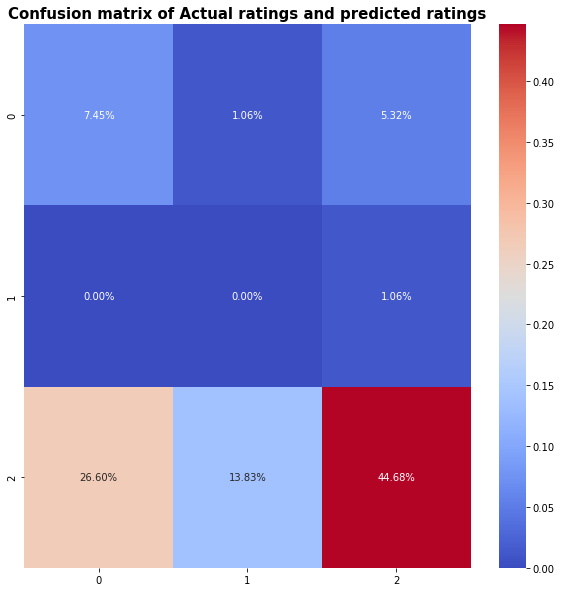

In [280]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dtc = DecisionTreeClassifier()

    dtc.fit(trainX_mimp, trainy_mimp)

    y_pred = dtc.predict(testX_mimp)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_mimp, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_mimp)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')
                

Text(0, 0.5, 'Score')

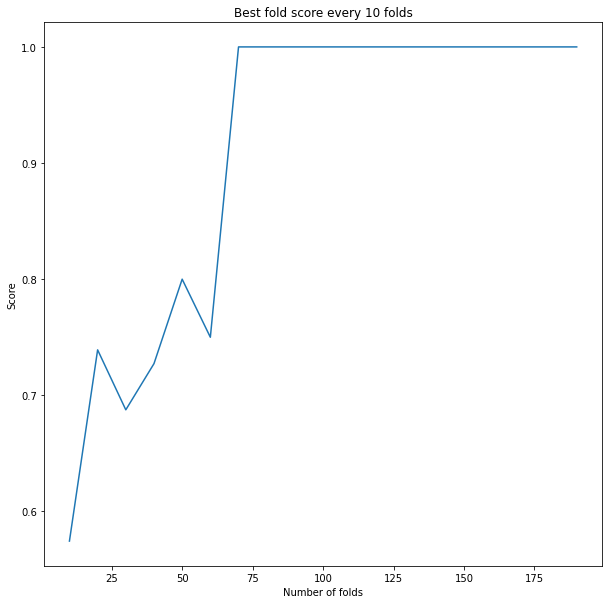

In [281]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(dtc, mimp, ally, cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Random Forest Classifier

Model accuracy score: 0.5106


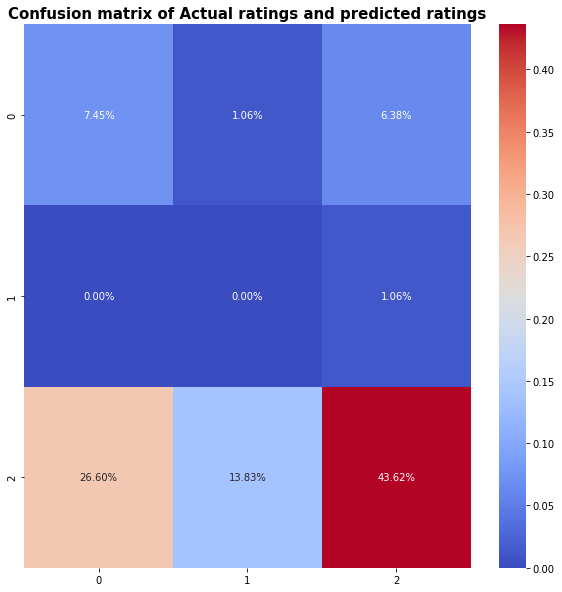

In [282]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rfc = RandomForestClassifier()

    rfc.fit(trainX_mimp, trainy_mimp)

    y_pred = rfc.predict(testX_mimp)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_mimp, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_mimp)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

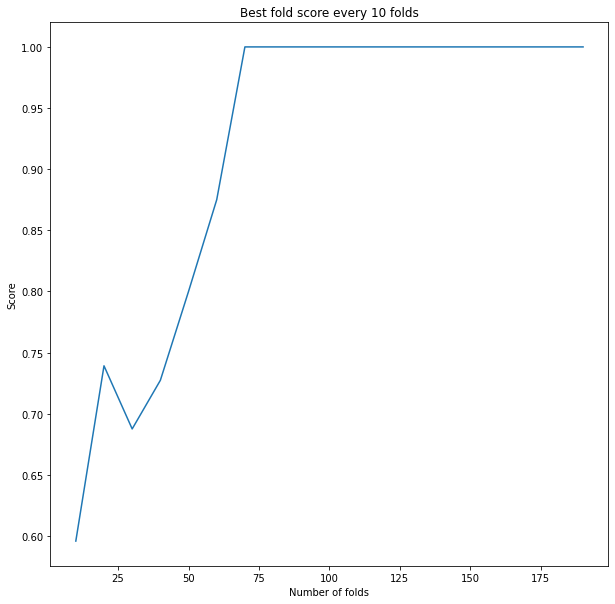

In [283]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(rfc, mimp, ally, cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Light Gradient Boosting

Model accuracy score: 0.5213


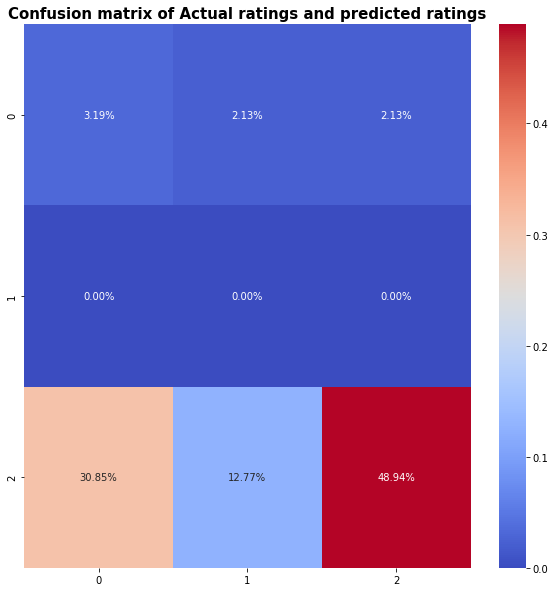

In [284]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lgbc = LGBMClassifier(
        objective="multiclass",
        n_estimators=200,
        metric="auc_mu",
        tree_learner="feature",
        random_state=42,
        num_iterations = 4000,
        learning_rate=0.1,
        silent=True,
        num_leaves = 3000,
        max_bin = 6)

    lgbc.fit(trainX_mimp, trainy_mimp)

    y_pred = lgbc.predict(testX_mimp)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_mimp, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_mimp)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

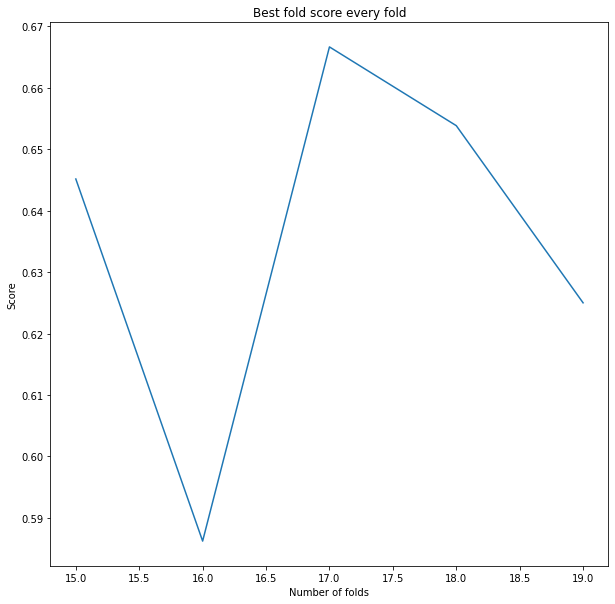

In [285]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(15,20):
        k_folds = KFold(n_splits = i)

        scores = cross_val_score(lgbc, mimp, ally, cv = k_folds)

        f_num.append(i)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every fold')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Balanced Dataset

In [286]:
sm = SMOTE(random_state=32)
trainX_mimp_balanced, trainy_mimp_balanced = sm.fit_resample(pd.DataFrame(trainX_mimp), pd.DataFrame(trainy_mimp))
testX_mimp_balanced, testY_mimp_balanced = sm.fit_resample(pd.DataFrame(testX_mimp), pd.DataFrame(testY_mimp))

<AxesSubplot:title={'center':'Class distributions'}, xlabel='length of stay groups'>

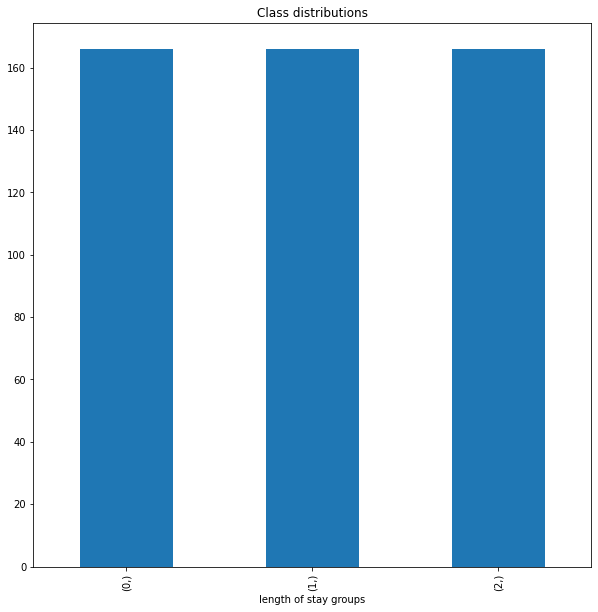

In [287]:
trainy_mimp_balanced.value_counts().plot(kind='bar', title='Class distributions', xlabel='length of stay groups')

Decision tree Classifier with balanced dataset

Model accuracy score: 0.4097


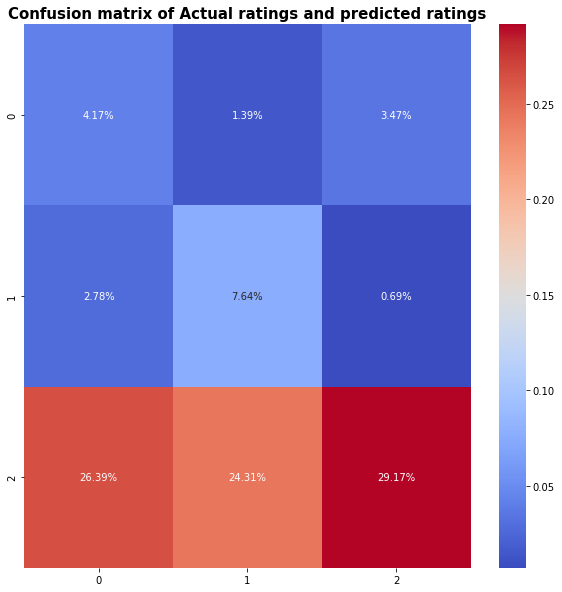

In [288]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dtc = DecisionTreeClassifier()

    dtc.fit(trainX_mimp_balanced, trainy_mimp_balanced)

    y_pred = dtc.predict(testX_mimp_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_mimp_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_mimp_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

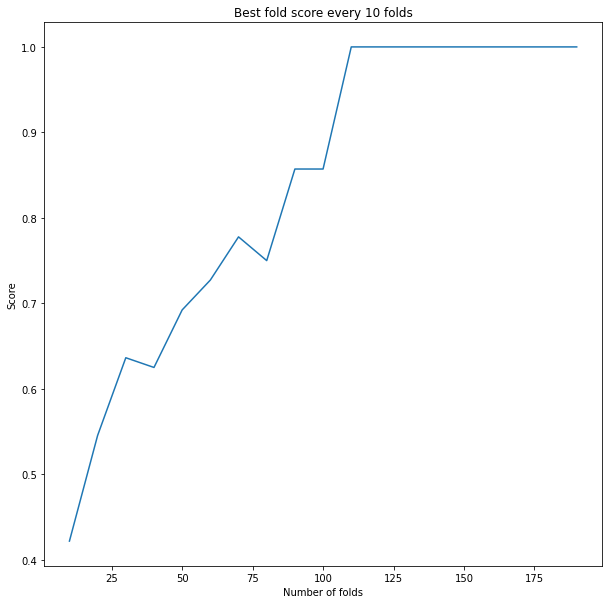

In [289]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(dtc, pd.concat([trainX_mimp_balanced,testX_mimp_balanced], axis=0), pd.concat([trainy_mimp_balanced,testY_mimp_balanced], axis=0), cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Random Forest classifier with balanced dataset

Model accuracy score: 0.4097


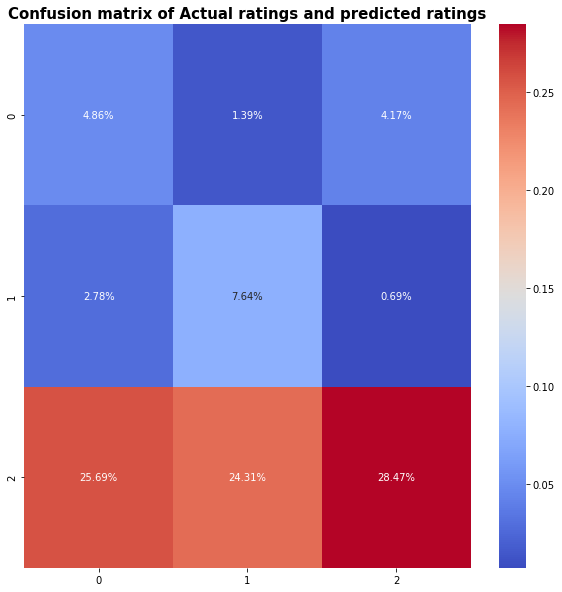

In [290]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rfc = RandomForestClassifier()

    rfc.fit(trainX_mimp_balanced, trainy_mimp_balanced)

    y_pred = rfc.predict(testX_mimp_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_mimp_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_mimp_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

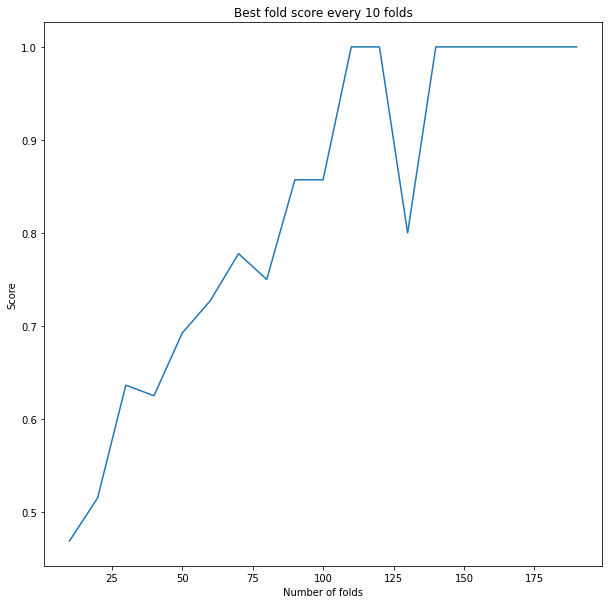

In [291]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(rfc, pd.concat([trainX_mimp_balanced,testX_mimp_balanced], axis=0), pd.concat([trainy_mimp_balanced,testY_mimp_balanced], axis=0), cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Light Gradient Boosting algorithm with balanced dataset

Model accuracy score: 0.3681


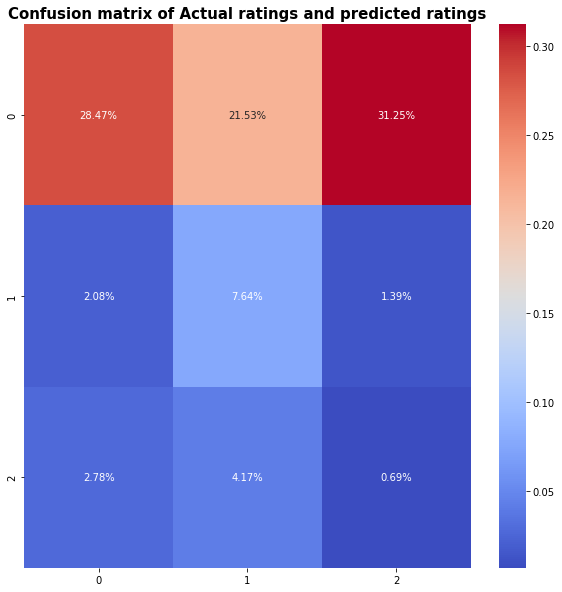

In [292]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lgbc = LGBMClassifier(
        objective="multiclass",
        n_estimators=200,
        metric="auc_mu",
        tree_learner="feature",
        random_state=42,
        num_iterations = 4000,
        learning_rate=0.1,
        silent=True,
        num_leaves = 3000,
        max_bin = 6)

    lgbc.fit(trainX_mimp_balanced, trainy_mimp_balanced)

    y_pred = lgbc.predict(testX_mimp_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_mimp_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_mimp_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

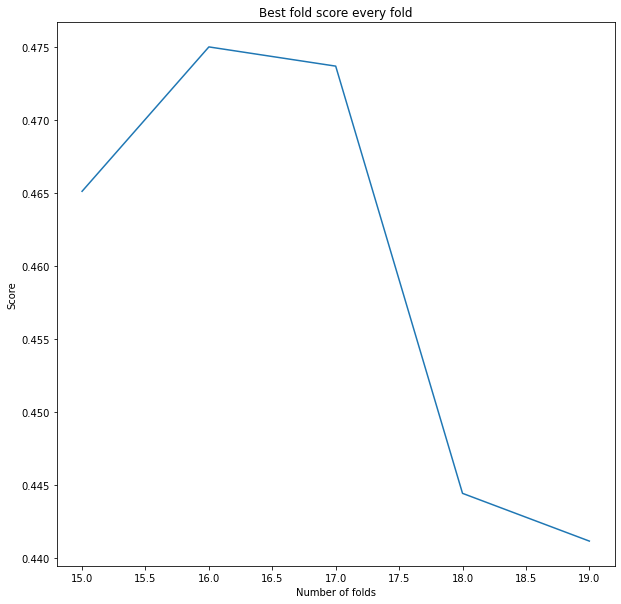

In [293]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(15,20):
        k_folds = KFold(n_splits = i)

        scores = cross_val_score(lgbc, pd.concat([trainX_mimp_balanced,testX_mimp_balanced], axis=0), pd.concat([trainy_mimp_balanced,testY_mimp_balanced], axis=0), cv = k_folds)

        f_num.append(i)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every fold')
plt.xlabel('Number of folds')
plt.ylabel('Score')

**Original Data**

In [294]:
x_original = x.copy()
y_original = y.copy()

x = x.fillna(-1)

trainX , testX, trainy, testY = train_test_split(x , y  , train_size=0.75)

Decision Tree Classifier

Model accuracy score: 0.3390


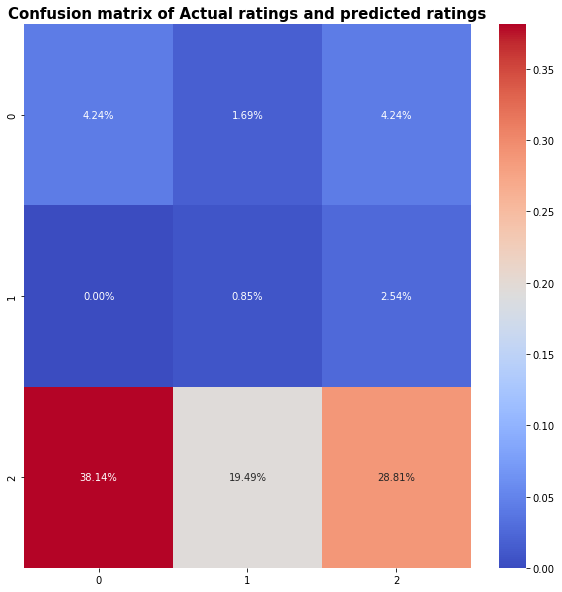

In [295]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dtc = DecisionTreeClassifier()

    dtc.fit(trainX, trainy)

    y_pred = dtc.predict(testX)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

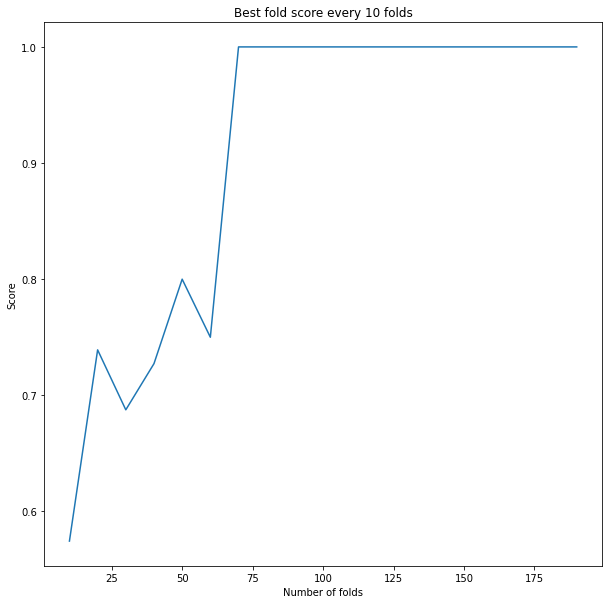

In [296]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(dtc, x, y, cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Random Forest Classifier

Model accuracy score: 0.3305


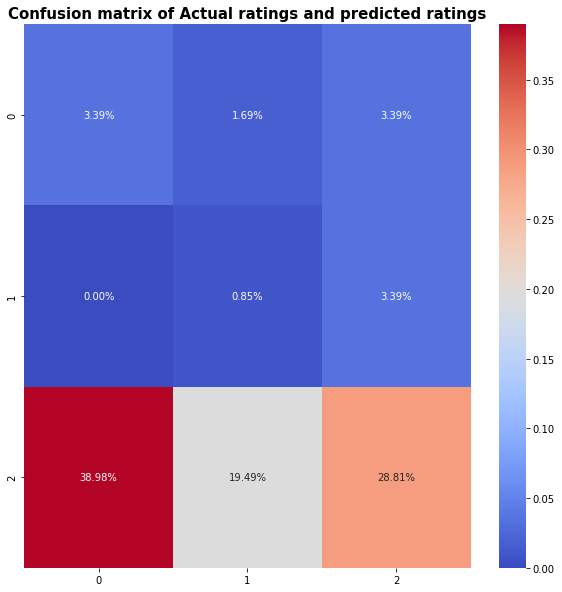

In [297]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rfc = RandomForestClassifier()

    rfc.fit(trainX, trainy)

    y_pred = rfc.predict(testX)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

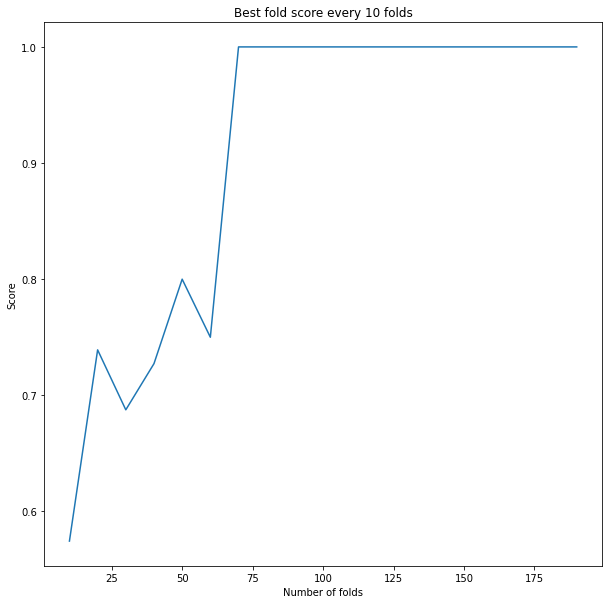

In [298]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(rfc, x, y, cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Light Gradient Boosting

Model accuracy score: 0.3559
Cross Validation Max Score:  0.7391304347826086


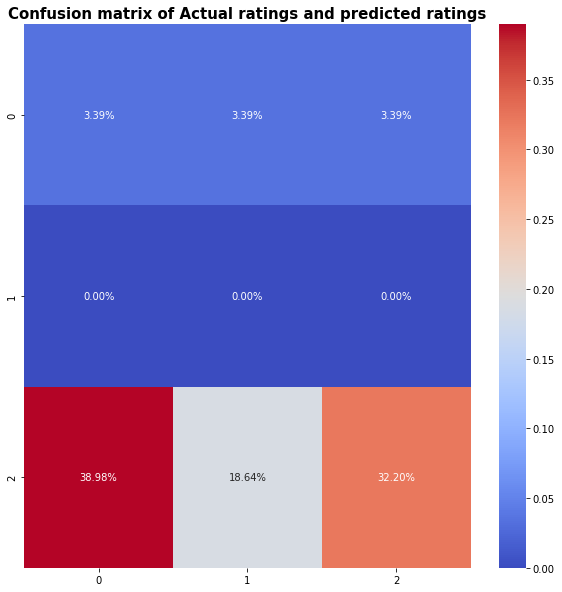

In [299]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lgbc = LGBMClassifier(
        objective="multiclass",
        n_estimators=200,
        metric="auc_mu",
        tree_learner="feature",
        random_state=42,
        num_iterations = 4000,
        learning_rate=0.1,
        silent=True,
        num_leaves = 3000,
        max_bin = 6)

    lgbc.fit(trainX, trainy)

    y_pred = lgbc.predict(testX)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

    k_folds = KFold(n_splits = 20)

    scores = cross_val_score(lgbc, x, y, cv = k_folds)

    print("Cross Validation Max Score: ", scores.max())

Text(0, 0.5, 'Score')

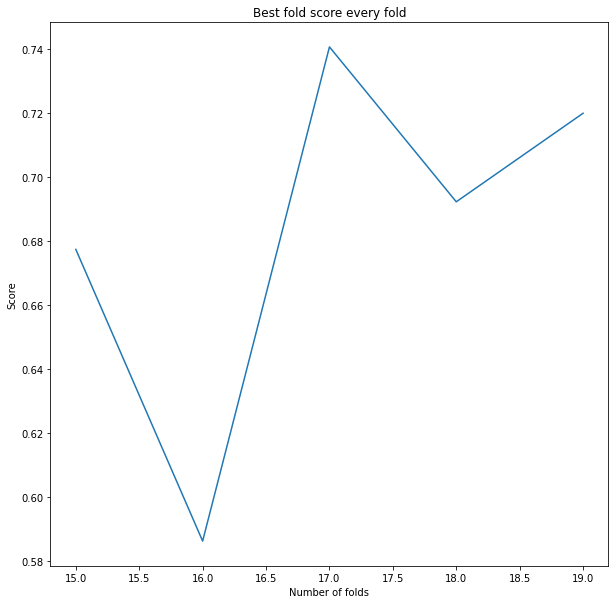

In [300]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(15,20):
        k_folds = KFold(n_splits = i)

        scores = cross_val_score(lgbc, x, y, cv = k_folds)

        f_num.append(i)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every fold')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Balanced Dataset

In [224]:
trainX_balanced, trainy_balanced = sm.fit_resample(pd.DataFrame(trainX), pd.DataFrame(trainy))
testX_balanced, testY_balanced = sm.fit_resample(pd.DataFrame(testX), pd.DataFrame(testY))

<AxesSubplot:title={'center':'Class distributions'}, xlabel='length of stay groups'>

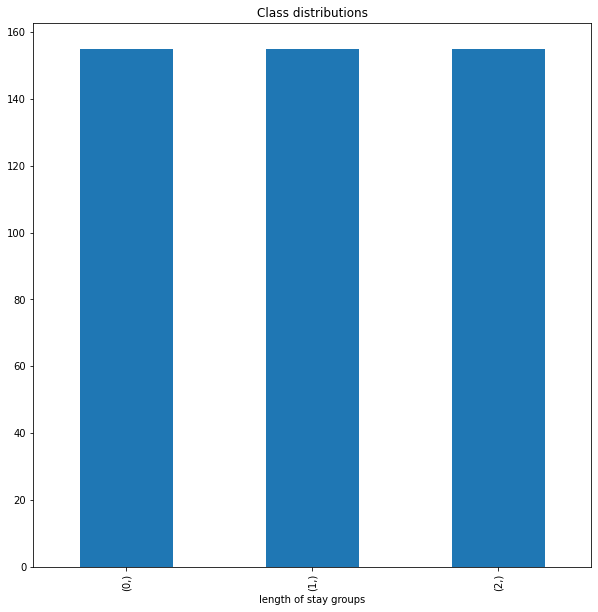

In [225]:
trainy_balanced.value_counts().plot(kind='bar', title='Class distributions', xlabel='length of stay groups')

Decision tree Classifier with balanced dataset

Model accuracy score: 0.3164


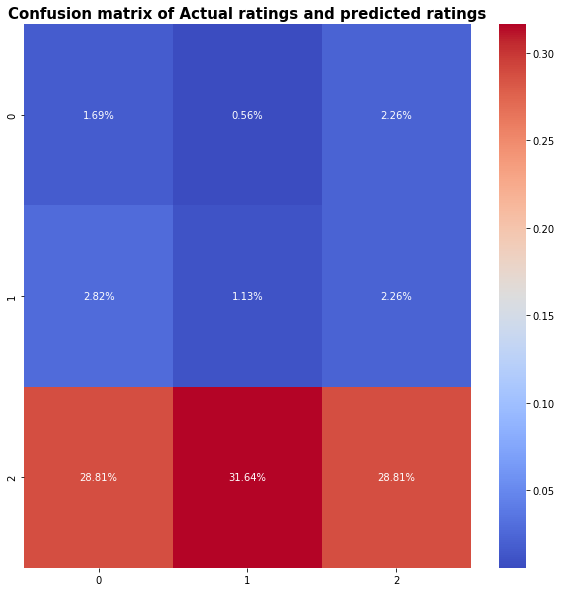

In [226]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dtc = DecisionTreeClassifier()

    dtc.fit(trainX_balanced, trainy_balanced)

    y_pred = dtc.predict(testX_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

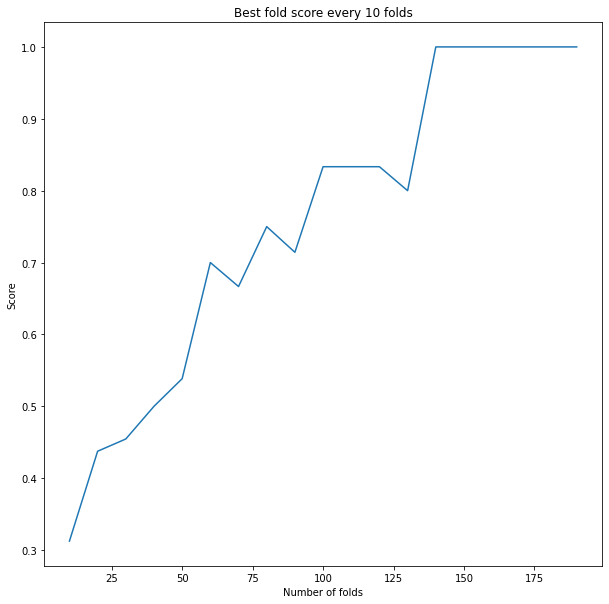

In [227]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(dtc, pd.concat([trainX_balanced,testX_balanced], axis=0), pd.concat([trainy_balanced,testY_balanced], axis=0), cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Random Forest classifier with balanced dataset

Model accuracy score: 0.3277


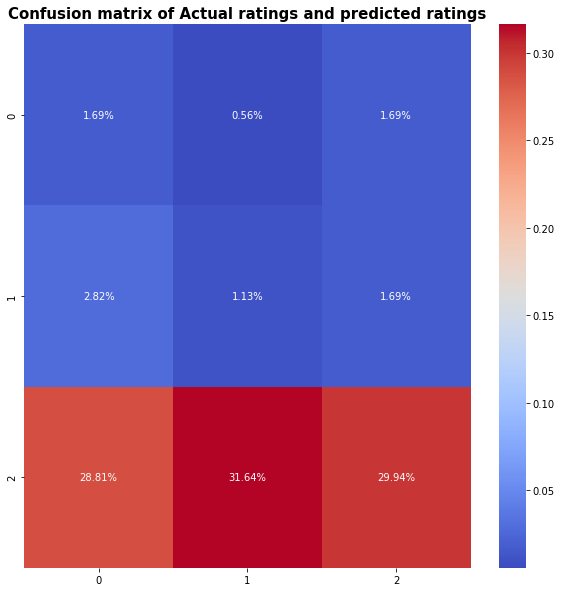

In [228]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rfc = RandomForestClassifier()

    rfc.fit(trainX_balanced, trainy_balanced)

    y_pred = rfc.predict(testX_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

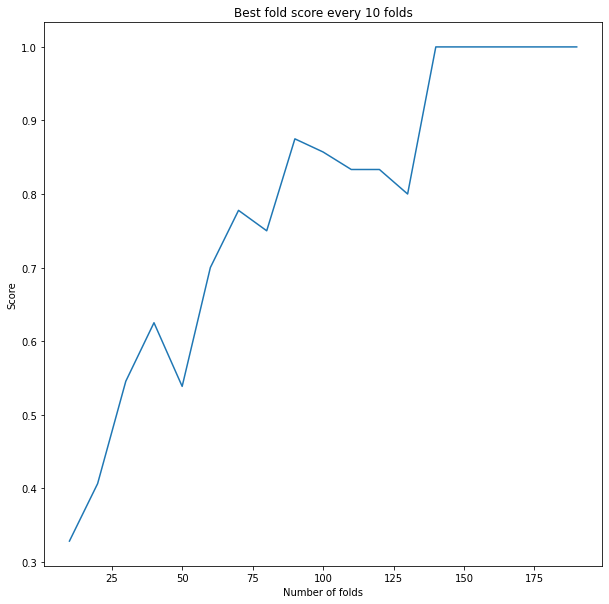

In [229]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20):
        k_folds = KFold(n_splits = i * 10)

        scores = cross_val_score(rfc, pd.concat([trainX_balanced,testX_balanced], axis=0), pd.concat([trainy_balanced,testY_balanced], axis=0), cv = k_folds)

        f_num.append(i*10)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every 10 folds')
plt.xlabel('Number of folds')
plt.ylabel('Score')

Light Gradient Boosting algorithm with balanced dataset

Model accuracy score: 0.3446


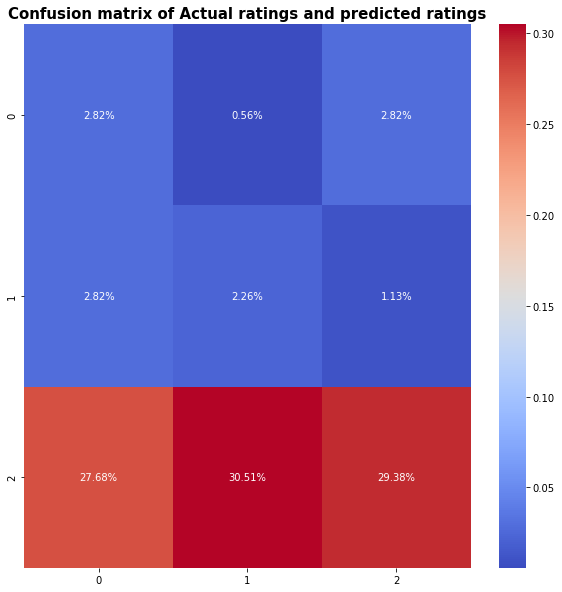

In [230]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lgbc = LGBMClassifier(
        objective="multiclass",
        n_estimators=200,
        metric="auc_mu",
        tree_learner="feature",
        random_state=42,
        num_iterations = 4000,
        learning_rate=0.1,
        silent=True,
        num_leaves = 3000,
        max_bin = 6)

    lgbc.fit(trainX_balanced, trainy_balanced)

    y_pred = lgbc.predict(testX_balanced)

    y_pred

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(testY_balanced, y_pred)))

    cf_matrix = confusion_matrix(y_pred, testY_balanced)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.title('Confusion matrix of Actual ratings and predicted ratings' , fontweight ='bold', fontsize = 15)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%' , cmap = 'coolwarm')

Text(0, 0.5, 'Score')

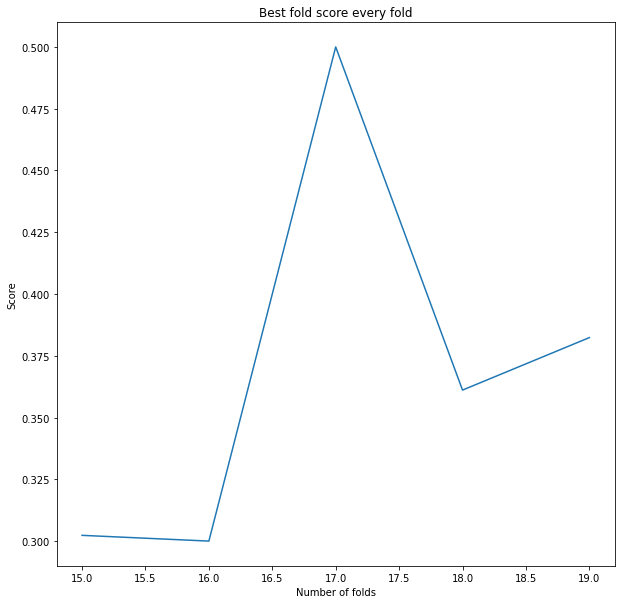

In [231]:
cvs = []
f_num = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(15,20):
        k_folds = KFold(n_splits = i)

        scores = cross_val_score(lgbc, pd.concat([trainX_balanced,testX_balanced], axis=0), pd.concat([trainy_balanced,testY_balanced], axis=0), cv = k_folds)

        f_num.append(i)
        cvs.append(scores.max())
plt.plot(f_num,cvs )
plt.title('Best fold score every fold')
plt.xlabel('Number of folds')
plt.ylabel('Score')